In [1]:

import numpy as np
import pprint
import sys
if "../" not in sys.path:
  sys.path.append("../") 



In [2]:
# OBS CURRENTLY NOT IN USE

# Minataur blocked paths

Blocked_minataur = {
    0: [],
    1: [x for x in range(0,6)],
    2: [5,11,17,23,29],
    3: [x for x in range(24,30)],
    4: [0,6,12,18,24]
}

Blocked_agent = {
    0: [],
    1: [16,17,25,26,27,28,0,1,2,3,4,5],
    2: [1,7,13,9,15,27,5,11,17,23,29],
    3: [10,11,19,20,21,22,24,25,26,27,28,29],
    4: [2,8,14,10,16,28,0,6,12,18,24]
}

agent_moves = {}
minataur_moves = {}

grid = np.arange(30).reshape((5,6))
it = np.nditer(grid, flags=['multi_index'])

while not it.finished:
    s = it.iterindex
    x,y  = it.multi_index
    
    moves_agent = []
    moves_minataur = []
    for move in range(4):
        
        if not s in Blocked_agent[move]:
            moves_agent.append(move)
        
        if not s in Blocked_minataur[move]:
            moves_minataur.append(move)
            
    moves_agent.append(4)
    
    agent_moves[s] = moves_agent
    minataur_moves[s] = moves_minataur
    
    it.iternext()



In [3]:
import numpy as np
import sys
from gym.envs.toy_text import discrete

STAY = 0
UP = 1
RIGHT = 2
DOWN = 3
LEFT = 4


class GridworldEnv(discrete.DiscreteEnv):
    """
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the bottom right corner. There is also an minatours that is moving randomly
    unifromaly, if he catches you, you will be eated. 

    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3, STAY=4).
    Actions going off the edge leave you in your current state with a reward -1.
    Actions going into a wall, leave you in your current state with a reward -1. 
    This make the agent learn not to bump into walls or edges. 
    
    You receive a reward of -1 at each step until you reach a terminal state.
    Your recive a reward of -10 if the minatours catches you
    
    There are 30*30 number of states, one state represent the tuple (agent_state, minataur_state) in the enviroment
    the full set of states descirbe all possible combination of theese states. 
    
    
    
    # LEFT TO FIX:
        Alter the proababilities and next states when the minataur is at an edge. Now prob=0.25 for any of the directions.
        Diffrent discount factors? 
            More important to avoid the minataurs then getting closer to the goal so discount factor < 1 is necessary.
    
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[5,6]):

        self.shape = shape
    
        # Number of states
        nS = 900
        #Number of actions
        nA = 5
        
        #Shape of the maze
        MAX_Y = shape[0] #5
        MAX_X = shape[1] #6
    
        #Translation Matrix, used to find the state index
        state_index = np.arange(nS).reshape((30,30))
        
        # Minataur blocked paths. Minataur can't go outside edges
        Edge_up = [x for x in range(0,6)]
        Edge_right = [5,11,17,23,29]
        Edge_down = [x for x in range(24,30)]
        Edge_left = [0,6,12,18,24]
        

        #Agents blocked paths. Agent can't go outside edges or into walls.
        Blocked_agent_up = [16,17,25,26,27,28,0,1,2,3,4,5]
        Blocked_agent_right = [1,7,13,9,15,27,5,11,17,23,29]
        Blocked_agent_down = [10,11,19,20,21,22,24,25,26,27,28,29]
        Blocked_agent_left = [2,8,14,10,16,28,0,6,12,18,24]
        
        #Init of transition matrix
        P = {}

        #Matrix (30*30) with all numbered possible states
        grid = np.arange(nS).reshape((30,30))
        #Iteration tool, instead of using two for loops
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:

            s = it.iterindex
            # x= agent current state (0-29) , y = minataur current state  (0-29)
            x,y  = it.multi_index

            #Stopping condition, when have reached terminal state (either end of maze or eaten)
            is_done = lambda x: x == 28
            is_eaten = lambda x,y: x == y
            #Negative reward for everytime step we are not in the terminal state
            reward = 0.0 if is_done(x) else -1.0
            #Negative reward if out state and the minataurs is the same(we have been eaten)
            if is_eaten(x,y) == True:
                reward = -1

                        
            P[s] = {a : [[]] for a in range(nA)}

            # We're stuck in a terminal state if the agent is in the terminal node, no matter where
            # the minataur is
            if is_done(x) or is_eaten(x,y):
                P[s][UP] = [([1.0], [s], [reward], True)]
                P[s][RIGHT] = [([1.0], [s], [reward], True)]
                P[s][DOWN] = [([1.0], [s], [reward], True)]
                P[s][LEFT] = [([1.0], [s], [reward], True)]
                P[s][STAY] = [([1.0], [s], [reward], True)]
            # Not a terminal state
            else:
                # First determine states depending on out choice of action
                #If we go up when we are at the top of maze, we end up the same pos.
                #If we go up when we are at any position in Walls_Up, we end up in same pos
                ns_up = x if x in Blocked_agent_up else x - MAX_X
                ns_right = x if x in Blocked_agent_right else x + 1
                ns_down = x if x in Blocked_agent_down else x + MAX_X
                ns_left = x if x in Blocked_agent_left else x - 1

                # Determine next state of the minataurs, 4 possibilies
                ns_m_up = y if y in Edge_up else y - MAX_X
                ns_m_right = y if y in Edge_right else y + 1
                ns_m_down = y if y in Edge_down else y + MAX_X
                ns_m_left = y if y in Edge_left else y -1

                # After an action a, we can be in four possible states. A total of 16 
            
                agent_next_states = [x,ns_up, ns_right, ns_down, ns_left]
                minataur_next_states = [y,ns_m_up, ns_m_right,ns_m_down, ns_m_left]
     
                action = 0
                
                # Buliding transition matrix P
                for ns in agent_next_states:
                    prob_list = []
                    next_state_list = []
                    reward_list = []

                    for ns_m in minataur_next_states:
                        reward = -1
                        ns_index = state_index[ns][ns_m]
                        next_state_list.append(ns_index)
                        prob_list.append(0.25)
                        
                        # If the agent next state == minataurs next state -> NO GOOD! 
                        if ns == ns_m:
                            reward=-50
                        # If the agent next state == minataurs current state -> EVEN WORSE!
                        if ns ==y:
                            reward = -50

                        reward_list.append(reward)
                    
                    
                    P[s][action] = [(prob_list,next_state_list, reward_list, is_done(ns))] 
                    action += 1
                    

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)


In [4]:
pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()

In [5]:
def value_iteration(env, theta=0.0001, discount_factor=0.8):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                #Prob a vector for the probabilities of the nex_state
                #Prob a vector for the possible next states
                # Rewards in thoose possible next states
               
                for i in range(len(prob)):
                    A[a] += prob[i] * (reward[i] + discount_factor * V[next_state[i]])
        
               
        return A
    
    V = np.zeros(env.nS)
    maxIter = 50
    i = 0
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        
        i +=1
        print("Delta-Value ", delta)
        if delta < theta:
            break
        if i >=maxIter:
            break
        
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V

In [6]:

policy, v = value_iteration(env)

#print("Policy Probability Distribution:")
#print(policy)
#print("")

#print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
#print(np.reshape(np.argmax(policy, axis=1), (30,30)))
#print("")

#print("Value Function:")
#print(v)
#print("")

#print("Reshaped Grid Value Function:")
#print(v.reshape((30,30)))
#print("")


pol = np.reshape(np.argmax(policy, axis=1), (30,30))

# pol[x][y] = Policy for the agent if agent is in field x and minataur is in field y.
# Ex. Pol[:,13].reshape((5,6)) shows the agent behavior in each field if the minataurs was sitatued in field nr 13.
pol[:,13].reshape((5,6))


Delta-Value  14.299199999999999
Delta-Value  7.717475840000002
Delta-Value  4.911613618176002
Delta-Value  3.8355623727104025
Delta-Value  3.3701874608668927
Delta-Value  2.942129985484179
Delta-Value  2.745033525083741
Delta-Value  2.63674204302173
Delta-Value  2.5071180084190274
Delta-Value  2.3419993491561435
Delta-Value  2.003428861003542
Delta-Value  1.7251384061422215
Delta-Value  1.4966763996774972
Delta-Value  1.290543651172399
Delta-Value  1.1070173746931893
Delta-Value  0.9382924071209331
Delta-Value  0.7925864375071257
Delta-Value  0.6679748990804697
Delta-Value  0.5620065013847366
Delta-Value  0.47222752196004336
Delta-Value  0.3963671980727881
Delta-Value  0.3323969050446749
Delta-Value  0.2785386391014981
Delta-Value  0.23325226159279566
Delta-Value  0.1952141397933076
Delta-Value  0.16329305063859323
Delta-Value  0.13652619441325697
Delta-Value  0.11409669069735173
Delta-Value  0.09531316114840394
Delta-Value  0.07959159130469828
Delta-Value  0.0664394425849153
Delta-Val

array([[3, 0, 2, 3, 4, 4],
       [0, 4, 2, 3, 1, 1],
       [3, 0, 2, 3, 2, 3],
       [0, 2, 2, 2, 2, 3],
       [1, 4, 4, 4, 0, 4]], dtype=int64)

In [7]:
def get_next_state(current_state, action):

    #Shape of the maze
    MAX_Y = 5
    MAX_X = 6
    
 
    if action == STAY:
        next_state = current_state
    
    if action == UP:
        next_state = current_state - MAX_X
        
    if action == RIGHT:
        next_state = current_state + 1
    
    if action == DOWN:
        next_state = current_state + MAX_X
        
    if action == LEFT:
        next_state = current_state - 1
    
    return next_state
        
    
    

In [8]:
from random import randint

# WORK IN PROGRESS

def simulation(policy,T, start_states, allowed_stay):
    
    
    """Simulating a policy in the Random Minotaur world. 
    Args : 
        policy - Policy in matrix form
        T - maximum time allowed in the maze
        start_states - A tuple (agent_state, minataur state) of the start state of the agent and the minotaur
        allowed stay - Booelan, if the minataur is allwed to stand still or no
        
    Returns : 
        A list of tupels [(agent_state, minataur state)] of the moves made by the agent and the minataur. 
        If_sucessful - Booelan if the agent sucessfully exit the maze before T
    """
    t = 0
    
    is_sucessful = False
    
    
    Blocked_minataur = {
    0: [], # You can always stay
    1: [x for x in range(0,6)],
    2: [5,11,17,23,29],
    3: [x for x in range(24,30)],
    4: [0,6,12,18,24]
}

    current_agent_state = start_states[0]
    current_minataur_state = start_states[1]
    
    states = []
    
    while t <= T:
        
        minataur_next_move = randint(0,4) if allowed_stay else randint(1,4)
        while current_minataur_state in Blocked_minataur[minataur_next_move]:
            minataur_next_move = randint(0,4) if allowed_stay else randint(1,4)
        
        # Get the best move for the agent
        agent_next_move = policy[current_agent_state, current_minataur_state]
        
        # Get the next states
        minataur_next_state = get_next_state(current_minataur_state, minataur_next_move)
        agent_next_state = get_next_state(current_agent_state, agent_next_move)
       
        current_agent_state = agent_next_state
        current_minataur_state = minataur_next_state
        
        #If the agent in the next move reaches the terminal state
        if current_agent_state == 28:
            is_sucessful = True
    
        
        states.append((agent_next_state, minataur_next_state))
        
        t += 1
        
        
    return (states, is_sucessful)    

In [9]:
T = 15
start_agent = 0
start_minataur = 28

counts = []

for T in range(9,30):
    count = 0
    for i in range(1000):
        
        states, is_sucessful = simulation(pol, T, [start_agent, start_minataur], True)
        
        if is_sucessful:
            count += 1
    counts.append(count/1000)
    print(T, count/1000)

    

9 0.145
10 0.303
11 0.436
12 0.527
13 0.595
14 0.658
15 0.72
16 0.791
17 0.834
18 0.851
19 0.847
20 0.906
21 0.911
22 0.935
23 0.946
24 0.942
25 0.963
26 0.974
27 0.972
28 0.979
29 0.979


Text(0.5,1,'Probability of exiting the maze as a function of T')

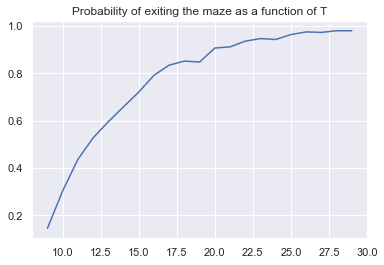

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

times = [T for T in range(9,30)]

# Plot the probability of exiting the maze as a function of the allowed time in the maze
plt.plot(times, counts)
plt.title("Probability of exiting the maze as a function of T")

Text(0.5,1,'Probability of exiting the maze as a function of T')

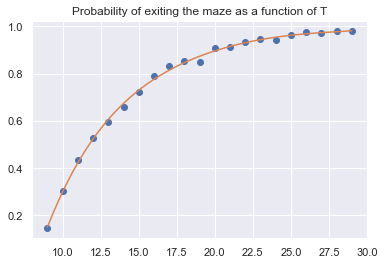

In [11]:
#Doing a bit more prettier curve fit

z = np.polyfit(times,counts,5)
f = np.poly1d(z)

times_new = np.linspace(times[0], times[-1], 50)
counts_new = f(times_new)

plt.plot(times, counts,'o', times_new, counts_new)
plt.title("Probability of exiting the maze as a function of T")

In [12]:
# Now assuming life is geometrically distributed with mean 30

T = np.random.geometric(1/30)




In [13]:
T

1

In [14]:
import tkinter as tk

def create_grid(event=None):
    w = c.winfo_width() # Get current width of canvas
    h = c.winfo_height() # Get current height of canvas
    c.delete('grid_line') # Will only remove the grid_line

    # Creates all vertical lines at intevals of 100
    for i in range(0, w, 100):
        
        if i == 200:
            c.create_line([(i, 0), (i, 3*h/5)], tag='grid_line', width=15)
            c.create_line([(i, 3*h/5), (i, h)], tag='grid_line')
        elif i == 400:
            c.create_line([(i, 0), (i, h/5)], tag='grid_line')
            c.create_line([(i, h/5), (i, 3*h/5)], tag='grid_line', width=15)
            c.create_line([(i, 3*h/5), (i, 4*h/5)], tag='grid_line')
            
            c.create_line([(i, 4*h/5), (i, h)], tag='grid_line', width = 15)
           
        else:
            c.create_line([(i, 0), (i, h)], tag='grid_line')
            

    # Creates all horizontal lines at intevals of 100
    for i in range(0, h, 100):
        
        if i == 400:
            c.create_line([(0, i), (w, i)], tag='grid_line')
            c.create_line([(w/6, i), (5*w/6, i)], tag='grid_line', width=15)
            
        elif i ==200:
            c.create_line([(0, i), (w, i)], tag='grid_line')
            c.create_line([(4*w/6, i), (6*w/6, i)], tag='grid_line', width=15)
            
        else: 
            c.create_line([(0, i), (w, i)], tag='grid_line')
    
    
                

root = tk.Tk()

c = tk.Canvas(root, height=500, width=600, bg='white')
c.pack(fill=tk.BOTH, expand=True)

c.bind('<Configure>', create_grid)

root.mainloop()